In [6]:
import pandas as pd
from Bio import SeqIO
from collections import defaultdict
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.ticker as tick
from matplotlib.ticker import ScalarFormatter
# matplotlib font parameters
font = {'family' : 'sans-serif',
        'sans-serif':['Arial'],
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

In [7]:

def read_gmst_nucleotides_file(gmst_nucleotides_filename):
    transdecorder_sequences = defaultdict(str)
    for record in SeqIO.parse(gmst_nucleotides_filename, 'fasta'):
        transdecorder_sequences[record.id] = str(record.seq)
    return transdecorder_sequences

def read_cpat_nucleotides_file(cpat_best_file, cpat_nucleotides_file):
    cpat_best = pd.read_table(cpat_best_file)
    best_orfs = set(cpat_best['ID'])
    cpat_sequences = defaultdict(str)
    for record in SeqIO.parse(cpat_nucleotides_file,'fasta'):
        if record.id in best_orfs:
            accession = record.id.split('_')[0]
            cpat_sequences[accession] = str(record.seq)
    return cpat_sequences
def read_transdecoder_nucleotides_file(transdecoder_nucleotides_file):
    transdecorder_sequences = defaultdict(str)
    for record in SeqIO.parse(transdecoder_nucleotides_file, 'fasta'):
        acc = record.id.split('.')[:-1]
        acc = '.'.join(acc)
        transdecorder_sequences[acc] = str(record.seq)
    return transdecorder_sequences

def compare_cpat_gmst(cpat, gmst):
    comparisons = []
    accessions = set(cpat.keys()).union(set(gmst.keys()))
    for accession in accessions:
        accession_comparison = ''
        if accession not in cpat.keys():
            accession_comparison = 'not_found_in_cpat'
        elif accession not in gmst.keys():
            accession_comparison = 'not_found_in_gmst'
        elif cpat[accession] == gmst[accession]:
            accession_comparison = 'same_orf_called'
        else:
            accession_comparison = 'different_orfs_called'
        comparisons.append([accession, accession_comparison])
    comparisons = pd.DataFrame(comparisons, columns=['PacBio Accession','Comparison'])
    return comparisons

def compare_gmst_transdecoder(gmst, transdecoder):
    comparisons = []
    accessions = set(gmst.keys()).union(set(transdecoder.keys()))
    for accession in accessions:
        accession_comparison = ''
        if accession not in gmst.keys():
            accession_comparison = 'not_found_in_gmst'
        elif accession not in transdecoder.keys():
            accession_comparison = 'not_found_in_transdecoder'
        elif gmst[accession] == transdecoder[accession]:
            accession_comparison = 'same_orf_called'
        else:
            accession_comparison = 'different_orfs_called'
        comparisons.append([accession, accession_comparison])
    comparisons = pd.DataFrame(comparisons, columns=['PacBio Accession','Comparison'])
    return comparisons

def compare_cpat_gmst_transdecoder(cpat, gmst, transdecoder):
    intersecting_accessions = set(cpat.keys()).union(set(gmst.keys())).union(set(transdecoder.keys()))
    rows = []
    for accession in intersecting_accessions:
        row = {
            'accession' : accession,
            'found in cpat': accession in cpat.keys(),
            'found in gmst': accession in gmst.keys(), 
            'found in transdecoder': accession in transdecoder.keys()
        }

        gmst_transdecoder = gmst.get(accession) == transdecoder.get(accession) and transdecoder.get(accession) != ''
        cpat_gmst = gmst.get(accession) == cpat.get(accession) and cpat.get(accession) != ''
        cpat_transdecoder = cpat.get(accession) == transdecoder.get(accession) and cpat.get(accession) != ''
        row['gmst_transdecoder'] = gmst_transdecoder
        row['cpat_gmst'] = cpat_gmst
        row['cpat_transdecoder'] = cpat_transdecoder
        row['cpat_gmst_transdecoder'] = cpat_gmst & cpat_transdecoder
        rows.append(row)
    full_comparision = pd.DataFrame(rows)
    return full_comparision







In [8]:
gmst_nucleotides_filename = '/Users/bj8th/Documents/Sheynkman-Lab/GitHub/Long-Read-Proteogenomics-Analysis/revisions/gmst/results/jurkat_corrected.5degfilter.fasta.fnn'
cpat_best_file = '/Users/bj8th/Documents/Sheynkman-Lab/Data/JURKAT_06-06-2021/cpat/jurkat.ORF_prob.best.tsv'
cpat_nucleotides_file = '/Users/bj8th/Documents/Sheynkman-Lab/Data/JURKAT_06-06-2021/cpat/jurkat.ORF_seqs.fa'
transdecoder_nucleotides_file = '/Users/bj8th/Documents/Sheynkman-Lab/GitHub/Long-Read-Proteogenomics-Analysis/revisions/transdecoder/analysis/jurkat_corrected.5degfilter.fasta.transdecoder.cds'


cpat_sequences = read_cpat_nucleotides_file(cpat_best_file, cpat_nucleotides_file)
gmst_sequences = read_gmst_nucleotides_file(gmst_nucleotides_filename)
transdecorder_sequences = read_transdecoder_nucleotides_file(transdecoder_nucleotides_file)



In [9]:
cpat_gmst = compare_cpat_gmst(cpat_sequences, gmst_sequences)
cpat_gmst.groupby('Comparison').size() / len(cpat_gmst)

Comparison
different_orfs_called    0.259309
not_found_in_cpat        0.000021
not_found_in_gmst        0.080007
same_orf_called          0.660663
dtype: float64

In [10]:
transdecoder_gmst = compare_gmst_transdecoder(gmst_sequences, transdecorder_sequences)
transdecoder_gmst.groupby('Comparison').size() / len(transdecoder_gmst)

Comparison
different_orfs_called        0.238704
not_found_in_gmst            0.075163
not_found_in_transdecoder    0.000662
same_orf_called              0.685472
dtype: float64

In [11]:
full_comparision = compare_cpat_gmst_transdecoder(cpat_sequences, gmst_sequences, transdecorder_sequences)

In [12]:
num_found_all = len(full_comparision[full_comparision['cpat_gmst_transdecoder']])
not_found_all = full_comparision[~full_comparision['cpat_gmst_transdecoder']]
num_found_cpat_gmst = len(not_found_all[not_found_all['cpat_gmst']])
num_found_cpat_transdecoder = len(not_found_all[not_found_all['cpat_transdecoder']])
num_found_gmst_transdecoder = len(not_found_all[not_found_all['gmst_transdecoder']])

no_overlap = not_found_all[(~not_found_all['gmst_transdecoder']) & (~not_found_all['cpat_gmst']) & (~not_found_all['cpat_transdecoder'])]
num_unique = len(no_overlap)

comparison_count = pd.DataFrame(
    [
        ['CPAT & GMST & TRANSDECODER', num_found_all], 
        ['CPAT & GMST', num_found_cpat_gmst], 
        ['CPAT & TRANSDECODER', num_found_cpat_transdecoder], 
        ['GMST & TRANSDECODER', num_found_gmst_transdecoder], 
        ['NO OVERLAP', num_unique]
        ], columns=['Category', 'Count'])

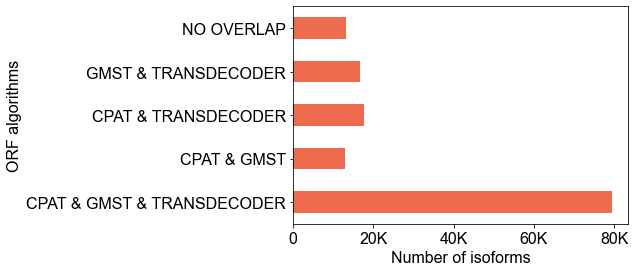

In [13]:
ax = comparison_count.plot.barh(y='Count',x='Category', color='#ee6c4d', legend=False)
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax.set_ylabel('ORF algorithms')
ax.set_xlabel('Number of isoforms')
plt.savefig('orf_calling_comparision.pdf', bbox_inches='tight')

<ipython-input-14-2e858b0a09db>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inchees" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('orf_calling.venn.pdf', bbox_inchees='tight')


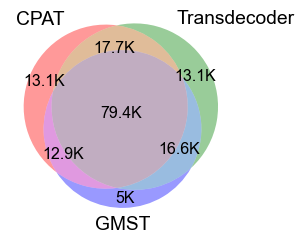

In [14]:
from matplotlib_venn import venn3, venn3_circles
cpat_only = len(no_overlap[no_overlap['found in cpat']])
transdecoder_only = len(no_overlap[no_overlap['found in transdecoder']])
gmst_only = len(no_overlap[no_overlap['found in gmst']])

v = venn3(subsets = (cpat_only, transdecoder_only, num_found_cpat_transdecoder, gmst_only, num_found_cpat_gmst, num_found_gmst_transdecoder, num_found_all), set_labels = ('CPAT', 'Transdecoder', 'GMST'))


for label in [ '001', '010', '100', '110', '011','101', '111']:
    size = int(v.get_label_by_id(label).get_text())
    new_text = reformat_large_tick_values(size,9)
    v.get_label_by_id(label).set_text(new_text)
plt.savefig('orf_calling.venn.pdf', bbox_inchees='tight')


,accession,found in cpat,found in gmst,found in transdecoder,gmst_transdecoder,cpat_gmst,cpat_transdecoder,cpat_gmst_transdecoder
0,PB.4597.31,True,True,True,True,True,True,True
1,PB.3916.20,True,True,True,True,True,True,True
2,PB.10518.1,True,True,True,True,True,True,True
3,PB.9473.9,True,True,True,True,True,True,True
4,PB.15171.10,True,True,True,False,False,True,False
...,...,...,...,...,...,...,...,...
139737,PB.9324.13,True,True,True,False,True,False,False
139738,PB.12088.60,True,True,True,True,True,True,True
139739,PB.2193.6,True,True,True,True,True,True,True
139740,PB.1968.12,True,True,True,True,True,True,True


In [23]:
ifile_protein_coding_genes  = '/Users/bj8th/Documents/Sheynkman-Lab/Data/JURKAT_06-06-2021/reference_tables/protein_coding_genes.txt'
ifile_pb_gene = '/Users/bj8th/Documents/Sheynkman-Lab/Data/JURKAT_06-06-2021/transcriptome_summary/pb_gene.tsv'
protein_coding_genes = list(pd.read_table(ifile_protein_coding_genes, header=None)[0])
pb_gene = pd.read_table(ifile_pb_gene)

full_comparision = full_comparision.merge(pb_gene, left_on='accession', right_on='pb_acc', how='left')
full_comparision['protein_coding_gene'] = full_comparision['gene'].isin(protein_coding_genes)

In [25]:
full_comparision.groupby('protein_coding_gene').size()

protein_coding_gene
True    139742
dtype: int64